In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as smf
np.random.seed(666)
plt.rcParams['figure.figsize'] = (15,9)
sns.set_style("whitegrid")

In [2]:
train = pd.read_csv('train.csv', index_col=0)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
test = pd.read_csv('test.csv', index_col=0)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
X = train.drop(columns=['Survived'])
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

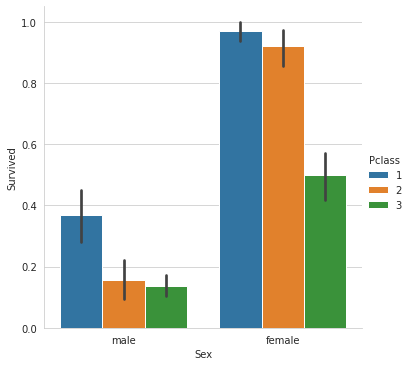

In [7]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train);

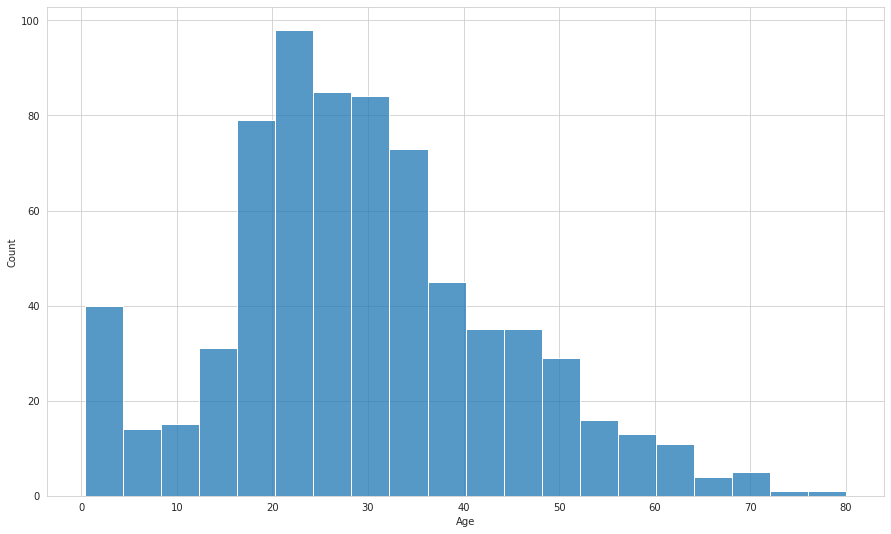

In [8]:
sns.histplot(train['Age']);

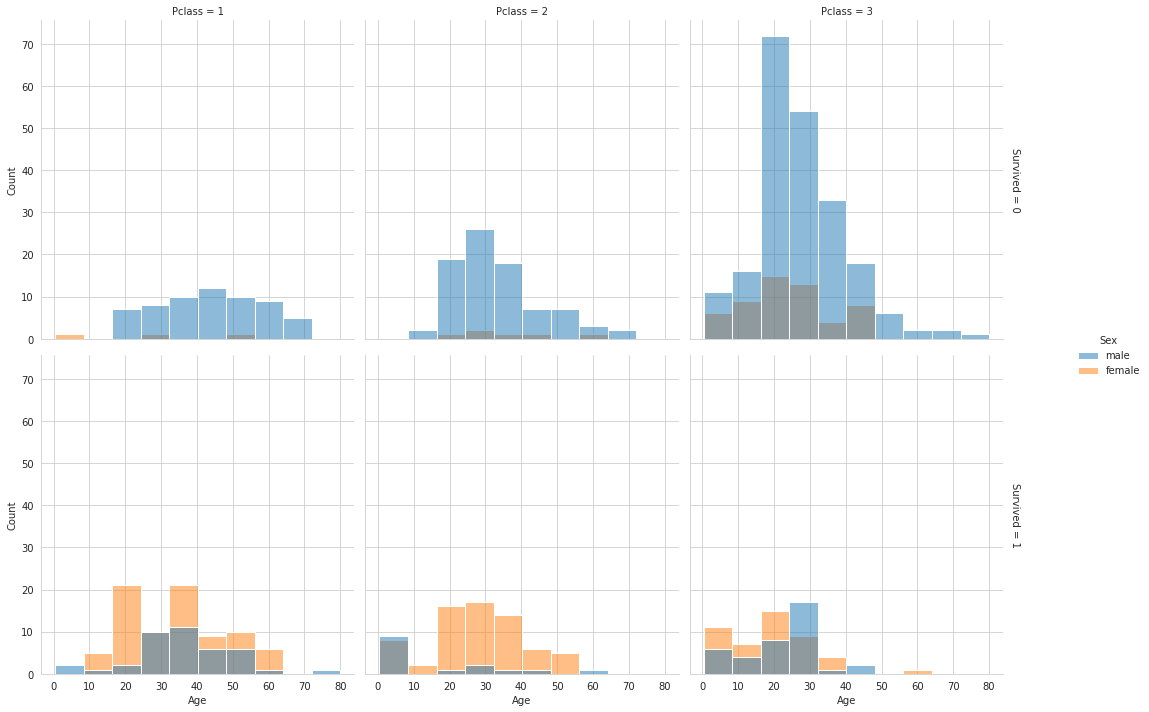

In [9]:
sns.displot(train, x='Age', hue='Sex', col='Pclass', row='Survived', facet_kws=dict(margin_titles=True), bins=10);

In [10]:
train["Family_Size"] = train["SibSp"] + train["Parch"] + 1

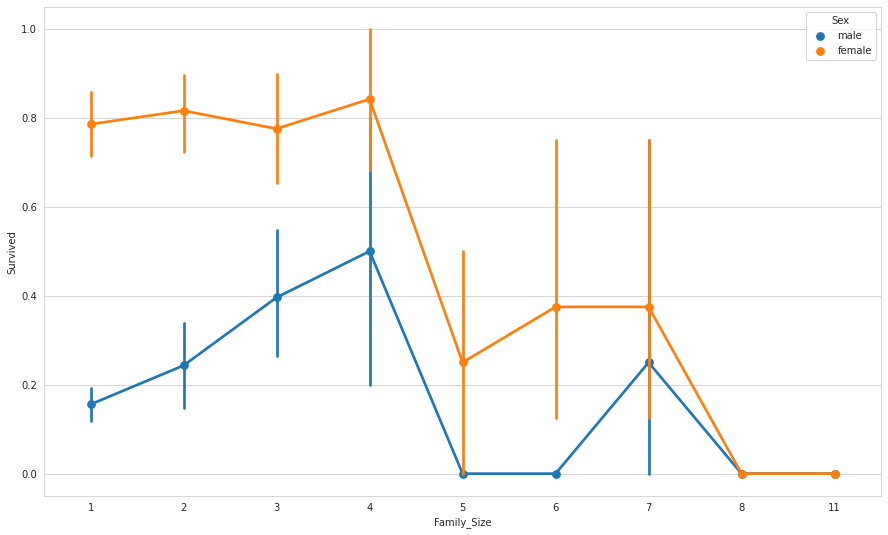

In [11]:
sns.pointplot(x="Family_Size", y="Survived", hue="Sex", data=train);

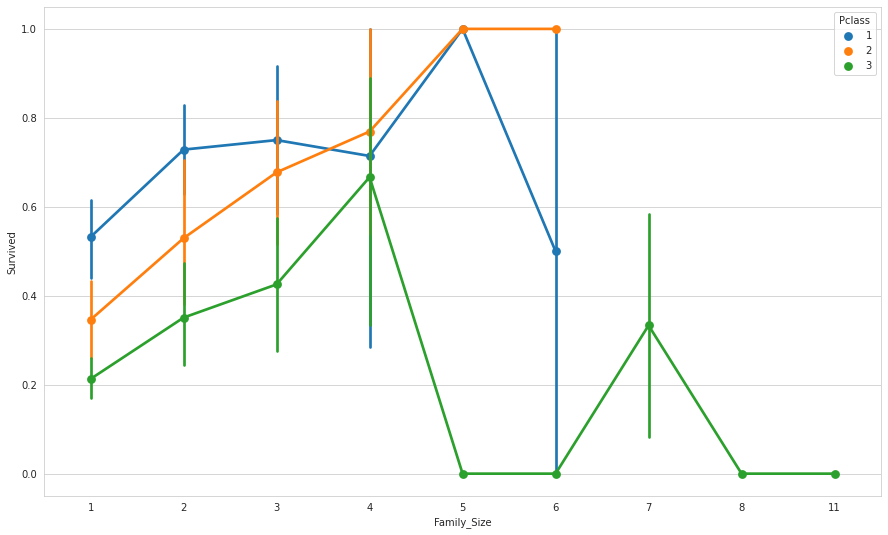

In [12]:
sns.pointplot(x="Family_Size", y="Survived", hue="Pclass", data=train);

In [13]:
pclass = ['Pclass']
pclass_pipeline = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

In [14]:
sex = ['Sex']
sex_pipeline = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

In [15]:
age = ['Age']
age_pipeline = Pipeline([
    ('imputation', SimpleImputer(strategy='median')),
    ('binning', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform' ))
])

In [16]:
def family_size(X_train):
    return pd.DataFrame(X_train['SibSp'] + X_train['Parch'] + 1)

In [17]:
fare = ['Fare']
fare_pipeline = Pipeline([('normalize', MinMaxScaler())])

In [18]:
embarked = ['Embarked']
embarked_pipeline = Pipeline([
    ('imputation', SimpleImputer(strategy='constant',fill_value='S')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
feature_engineering = ColumnTransformer([
     ('class_encoding', pclass_pipeline, pclass),
     ('sex_encoding', sex_pipeline, sex),
     ('age_binning',age_pipeline, age),
     ('define_family', FunctionTransformer(family_size), ['Parch', 'SibSp']),
     ('normalize_fare', fare_pipeline, fare),
     ('embarked_encoding', embarked_pipeline, embarked)
])

In [20]:
#feature_engineering.named_transformers_['class_encoding'].get_feature_names()

In [21]:
feature_engineering.fit(X_train)

ColumnTransformer(transformers=[('class_encoding',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Pclass']),
                                ('sex_encoding',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex']),
                                ('age_binning',
                                 Pipeline(steps=[('imputation',
                                                  SimpleImputer(strategy='median')),
                                                 ('binning',
                                                  KBinsDiscretizer(en...
                                ('define_family',
                                 FunctionTransformer(func=<function family_size at 0x7f92aeb6d940>),
     

In [22]:
X_train_fe = feature_engineering.fit_transform(X_train)
X_train_fe

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [23]:
X_train_fe.shape

(712, 11)

In [24]:
pd.DataFrame(X_train_fe).head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.113168,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.015127,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.014102,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.015094,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.123667,1.0,0.0,0.0


In [25]:
exp_df_X = pd.DataFrame(X_train_fe)
exp_df_y = y_train
exp_df_X.shape, exp_df_y.shape

((712, 11), (712,))

In [26]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6, random_state=999)
random_forest.fit(exp_df_X, exp_df_y)
round(random_forest.score(exp_df_X, exp_df_y),2)

0.86

In [27]:
var_imp_dic = dict(zip(exp_df_X.columns, random_forest.feature_importances_))
var_imp_dic_df = pd.DataFrame.from_dict(var_imp_dic, orient='index')
var_imp_dic_df.columns = ['VarImp']
var_imp_dic_df.reset_index(inplace=True)
var_imp_dic_df = var_imp_dic_df.rename(columns = {'index':'Var'})
var_imp_dic_df = var_imp_dic_df.sort_values(by='VarImp', ascending = False)
var_imp_dic_df

,Var,VarImp
3,3,0.232467
4,4,0.213402
7,7,0.199232
6,6,0.096042
2,2,0.092959
0,0,0.053038
5,5,0.041852
1,1,0.024715
10,10,0.020112
8,8,0.015675


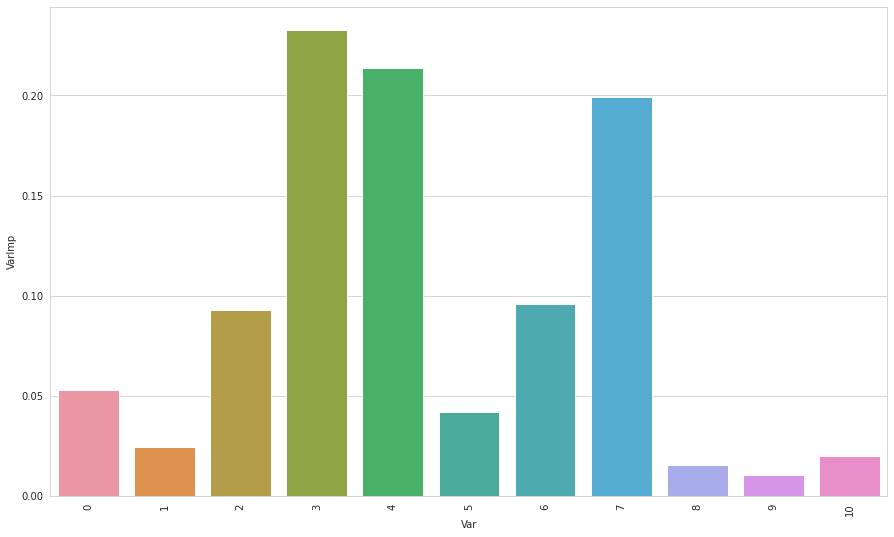

In [28]:
bp = sns.barplot(x='Var', y='VarImp', data=var_imp_dic_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);

In [29]:
logistic_regression = LogisticRegression(random_state=321, max_iter=5000, class_weight='balanced')
logistic_regression.fit(exp_df_X, exp_df_y)
round(logistic_regression.score(X_train_fe, y_train), 2)

0.77

In [30]:
cross_val_accuracy = cross_val_score(estimator=logistic_regression, X=X_train_fe, y=y_train, cv=5, scoring='accuracy')
cross_val_accuracy

array([0.75524476, 0.74125874, 0.76760563, 0.77464789, 0.76760563])

In [31]:
round(cross_val_accuracy.mean(), 2)

0.76

In [32]:
RF_CV_acc = cross_val_score(estimator=random_forest, X=X_train_fe, y=y_train, cv=5, scoring='accuracy')
RF_CV_acc, RF_CV_acc.mean()

(array([0.81118881, 0.79020979, 0.78873239, 0.79577465, 0.80985915]),
 0.7991529597163399)

In [33]:
X_test_fe = pd.DataFrame(feature_engineering.transform(X_test))
X_test_fe.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.021731,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.014110,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.054164,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.065388,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.028213,1.0,0.0,0.0


In [34]:
round(random_forest.score(X_test_fe, y_test), 2)

0.84

In [35]:
test_fe = feature_engineering.transform(test)
test_fe

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [36]:
test_fe.shape

(418, 11)

In [37]:
pd.DataFrame(test_fe).head(20)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.015282,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.013663,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.018909,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.016908,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.023984,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.018006,0.0,0.0,1.0
6,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.014891,0.0,1.0,0.0
7,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.056604,0.0,0.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.014110,1.0,0.0,0.0
9,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.047138,0.0,0.0,1.0


In [38]:
Survived = random_forest.predict(test_fe) ### ???

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').